주말동안 읽을 것:\
https://www.tensorflow.org/tutorials/images/segmentation

# Step2: U-net MNIST's image segmentation

- Restore ruined MNIST data by fitting in U-net model

## Before a start
### check and change version of keras and tensorflow

In [0]:
# !pip uninstall keras
# !pip install keras==2.1.5

import keras
keras.__version__

"""
Using TensorFlow backend.
'2.1.5'
"""

Using TensorFlow backend.


'2.1.5'

In [1]:
# in case of using colab
%tensorflow_version 1.x

TensorFlow 1.x selected.


Ref: \
https://github.com/YBIGTA/data-science-2018/blob/master/DLCV/2018-02-10-Keras-U-Net-starter.md
\
https://towardsdatascience.com/a-simple-2d-cnn-for-mnist-digit-recognition-a998dbc1e79a

my_unet_01_유동2.ipynb by Juwon lee

## Load module and prepare data

In [0]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, UpSampling2D, BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K


import tensorflow as tf

from numpy import expand_dims
from tensorflow.keras.datasets import mnist


## Before starting
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed


## Load MNIST data
(X_train, _), (x_test, _) = mnist.load_data()
train = expand_dims(X_train, axis=-1)
test = expand_dims(x_test, axis=-1)

train_ids, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = train.shape  # (60000, 28, 28, 1)
test_ids, _, _, _ = test.shape # (10000, 28, 28, 1)


## Data Normalization (inputs)
train = train.astype('float32')
train = train / 255.0

test = test.astype('float32')
test = test / 255.0

## Prepare inputs(ruined) and outputs(normal) of training data
normal = train

# noise range for ruined
rrn = 5

ruined = train.copy()

for i in range(0, ruined.shape[0]):
  x = np.random.randint(0, ruined.shape[1]-rrn)
  y = np.random.randint(0, ruined.shape[1]-rrn)
  z = np.random.randint(0, ruined.shape[1]-rrn)
  ruined[i, 5:19, x : x+rrn] = 1.
  ruined[i, y : y+rrn, 2:10] = 1.
  ruined[i, z : z+rrn, z : z+rrn] = 1.

## Prepare inputs(ruined) and outputs(normal) of testing data
test_normal = test

# noise range for test_ruined
trn = 3

test_ruined = test.copy()
for i in range(0, test_ruined.shape[0]):
  x = np.random.randint(0, test_ruined.shape[1]-trn)
  y = np.random.randint(0, test_ruined.shape[1]-trn)
  z = np.random.randint(0, test_ruined.shape[1]-trn)
  test_ruined[i, 5:19, x : x+trn] = 1.
  test_ruined[i, y : y+trn, 2:10] = 1.
  test_ruined[i, z : z+trn, z : z+trn] = 1.

## Check data with visuals 

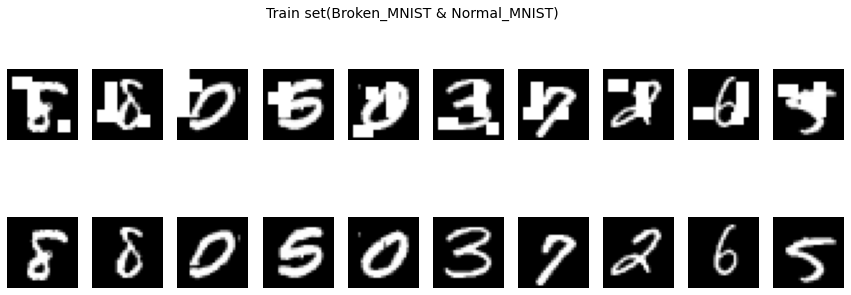

In [3]:
# Check if training data looks all right

fig, axs = plt.subplots(2,10, figsize=(15, 5))
for i in range(10) :
    ix = random.randint(0, train_ids)
    fig.suptitle('Train set(Broken_MNIST & Normal_MNIST)', fontsize=14)
    axs[0, i].set_axis_off()
    axs[0, i].imshow(ruined[ix].reshape(28,28), cmap='gray')
    axs[1, i].set_axis_off()
    axs[1, i].imshow(normal[ix].reshape(28,28), cmap='gray')

## Build U-net model

In [4]:
# Build U-Net model
def unet(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)
    s = Lambda(lambda x: x / 255) (inputs)

    # peak 3 (1, 2까지만 maxpooling)
    # 6 - 2
    # 7 - 1
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)
    
    # peak
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    
    u4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u4)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    
    u5 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c4)
    u5 = concatenate([u5, c1], axis=3)
    c5 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u5)
    c5 = Dropout(0.2) (c5)
    c5 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c5)
    
    return Model(inputs=[inputs], outputs=[outputs])

model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 28, 28, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 16)   160         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout) 

## Model Fitting

In [5]:
# Fitting

# earlystopper = EarlyStopping(patience=5, verbose=1)
# checkpointer = ModelCheckpoint('model-2020-1.h5', verbose=1, save_best_only=True)
# checkpointer = ModelCheckpoint(filepath = 'model_2020_05.hdf5', verbose=1, save_best_only=True, save_weights_only = True)
# hist = model.fit(ruined, normal, validation_split=0.1, batch_size=10, epochs=50, callbacks=[checkpointer, earlystopper])

hist = model.fit(ruined, normal, validation_split=0.1, batch_size=10, epochs=10)

model.save('unet.h5')

# score = model.evaluate(test_ruined, test_normal, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 34s 621us/sample - loss: 0.1051 - acc: 0.8099 - val_loss: 0.0838 - val_acc: 0.8135
Epoch 2/10
54000/54000 [==============================] - 32s 592us/sample - loss: 0.0824 - acc: 0.8133 - val_loss: 0.0797 - val_acc: 0.8125
Epoch 3/10
54000/54000 [==============================] - 32s 586us/sample - loss: 0.0788 - acc: 0.8137 - val_loss: 0.0757 - val_acc: 0.8142
Epoch 4/10
54000/54000 [==============================] - 32s 586us/sample - loss: 0.0771 - acc: 0.8139 - val_loss: 0.0745 - val_acc: 0.8145
Epoch 5/10
54000/54000 [==============================] - 32s 585us/sample - loss: 0.0761 - acc: 0.8140 - val_loss: 0.0739 - val_acc: 0.8146
Epoch 6/10
54000/54000 [==============================] - 32s 595us/sample - loss: 0.0753 - acc: 0.8141 - val_loss: 0.0732 - val_acc: 0.8144
Epoch 7/10
54000/54000 [==============================] - 32s 602us/sample - loss: 0.0748 - acc: 0.8142 -

In [20]:
# print(type(hist))

<class 'tensorflow.python.keras.callbacks.History'>


In [6]:
score = model.evaluate(test_ruined, test_normal, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.07722239427566528
Test accuracy: 0.81034106


## Visualize accuracy and loss

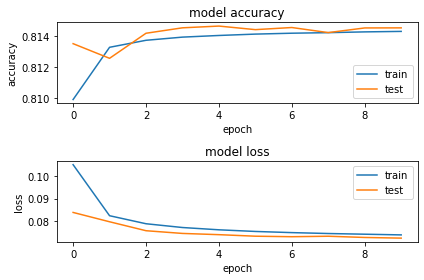

In [7]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

## Make plots to check the result

1/1 [==============================] - 0s 3ms/sample - loss: 0.0863 - acc: 0.7398


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


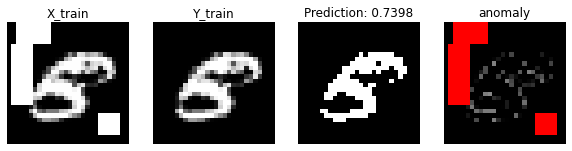

1/1 [==============================] - 0s 3ms/sample - loss: 0.1051 - acc: 0.7921


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


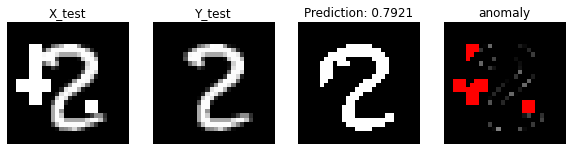

In [8]:
def plotPredictions(model, x_train, y_train, x_test, y_test):
    ix = np.random.randint(0, len(x_train))

    input_ = x_train[ix:ix+1]
    mask_ = y_train[ix:ix+1]

    preds_train = model.predict(input_)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)

    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(input_[0].reshape((28,28)), 'gray')

    plt.subplot(1,4,2)
    plt.title("Y_train")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')

    plt.subplot(1,4,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train_t[0][:,:,0], 'gray')

    # detect residual in train data
    train_residual = input_ - preds_train_t
    train_residual_ = train_residual.reshape((28,28))

    # transformed into 3 channels (RGB)
    train_residual_ = np.stack((train_residual_,)*3, -1)
    rows, cols, channels = train_residual_.shape

    # changing 255 to 0 in first channel
    for i in range(rows): 
        for j in range(cols):
            if train_residual_[i, j, 0] == 1 :
                train_residual_[i, j, 0] = 1

    for i in range(rows):
        for j in range(cols):
            if train_residual_[i, j, 1] == 1 :
                train_residual_[i, j, 1] = 0

    for i in range(rows):
        for j in range(cols):
            if train_residual_[i, j, 2] == 1 :
                train_residual_[i, j, 2] = 0            

    plt.subplot(1,4,4)
    plt.title("anomaly")
    plt.axis('off')
    plt.imshow(train_residual_)
    plt.show()
    plt.close()

    ix = np.random.randint(0, len(x_test))
    input_ = x_test[ix:ix+1]
    mask_ = y_test[ix:ix+1]
    preds_test = model.predict(input_)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)

    plt.figure(figsize=(10,10))
    plt.subplot(1,4,1)
    plt.title("X_test")
    plt.axis('off')
    plt.imshow(input_[0].reshape((28,28)), 'gray')

    plt.subplot(1,4,2)
    plt.title("Y_test")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')

    plt.subplot(1,4,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_test_t[0][:,:,0], 'gray')

    # detect residual in test data
    test_residual = input_ - preds_test_t
    test_residual_ = test_residual.reshape((28,28))

    # transformed into 3 channels (RGB)
    test_residual_ = np.stack((test_residual_,)*3, -1)
    rows, cols, channels = test_residual_.shape
    
    # changing 255 to 0 in first channel
    for i in range(rows):
        for j in range(cols):
            if test_residual_[i, j, 0] == 1 :
                test_residual_[i, j, 0] = 1

    for i in range(rows):
        for j in range(cols):
            if test_residual_[i, j, 1] == 1 :
                test_residual_[i, j, 1] = 0

    for i in range(rows):
        for j in range(cols):
            if test_residual_[i, j, 2] == 1 :
                test_residual_[i, j, 2] = 0            

    plt.subplot(1,4,4)
    plt.title("anomaly")
    plt.axis('off')
    plt.imshow(test_residual_)
    plt.show()
    plt.close()

# plot with color
plotPredictions(model, ruined, normal, test_ruined, test_normal)

# Step3 output -> dcgan discriminator -> 0 or 1
1. output prediction 개선할 것
2. dcgan discriminator 개선 후 output 입력해볼 것